In [8]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial15"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/var/folders/tn/2lzs5bpd7359frdhy_czpt4h0000gn/T/ipykernel_2817/3691048910.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


Device: cpu


In [59]:
from typing import Any, Callable, Optional, Tuple
from omegaconf import DictConfig, OmegaConf
import pandas as pd
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

In [9]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/"
# Files to download
pretrained_files = ["tutorial15/ViT.ckpt", "tutorial15/tensorboards/ViT/events.out.tfevents.ViT",
                    "tutorial5/tensorboards/ResNet/events.out.tfevents.resnet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name.split("/",1)[1])
    if "/" in file_name.split("/",1)[1]:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [56]:
config = OmegaConf.load('./../config/birds_train.yml')

config.SPEECH.CAPTIONS_PER_IMAGE   

10

In [209]:
def get_imgs(img_path, imsize, bbox=None, transform=None, normalize=None):
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)
        img = img.crop([x1, y1, x2, y2])

    if transform is not None:
        img = transform(img)

    return img # normalize(img) # 
    
class SpeechDataset(data.Dataset):

    def __init__(
        self, 
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        img_size: int = 64,
        target_transform: Optional[Callable] = None,
        ) -> None:

        #super().__init__(root, transform=transform, target_transform=target_transform)
        super().__init__()

        self.train = train
        self.transform = transform

        self.norm = transforms.Compose([
            transforms.Resize(int(256 * 76 / 64)),
            transforms.RandomCrop(256),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.target_transform = target_transform

        self.embeddings_num = config.SPEECH.CAPTIONS_PER_IMAGE   

        self.imsize = img_size

        self.root = root

        if root.find('birds') != -1 or root.find('FFHQ-Text') != -1:   
            self.bbox = self.load_bbox()

        if self.train:
            split_dir = os.path.join(root, 'train')
            self.filenames = self.load_filenames(root, 'train')
        else:
            split_dir = os.path.join(root, 'test')
            self.filenames = self.load_filenames(root, 'test')

        self.class_id = self.load_class_id(split_dir, len(self.filenames))

        if config.DATASET_NAME == 'birds' or config.DATASET_NAME == 'flowers':
            if self.train:
                unique_id = np.unique(self.class_id)
                seq_labels = np.zeros(config.DATASET_ALL_CLSS_NUM)
                for i in range(config.DATASET_TRAIN_CLSS_NUM):
                    seq_labels[unique_id[i]-1]=i
                
                self.labels = seq_labels[np.array(self.class_id)-1]    

    def load_bbox(self):
        data_dir = self.root
        bbox_path = os.path.join(data_dir, 'CUB_200_2011/bounding_boxes.txt')
        df_bounding_boxes = pd.read_csv(bbox_path,
                                        delim_whitespace=True,
                                        header=None).astype(int)

        filepath = os.path.join(data_dir, 'CUB_200_2011/images.txt')
        df_filenames = \
            pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist()
        print('Total filenames: ', len(filenames), filenames[0])
    
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        for i in range(0, numImgs):
            # bbox = [x-left, y-top, width, height]
            bbox = df_bounding_boxes.iloc[i][1:].tolist()

            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        
        return filename_bbox

    def load_class_id(self, data_dir, total_num):
        if os.path.isfile(data_dir + '/class_info.pickle'):
            with open(data_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f, encoding="bytes")
        else:
            class_id = np.arange(total_num)
        return class_id

    def load_filenames(self, data_dir, split):      
        filepath = '%s/%s/filenames.pickle' % (data_dir, split)
        if os.path.isfile(filepath):
            with open(filepath, 'rb') as f:
                filenames = pickle.load(f)     #filenames中保存的形式'002.Laysan_Albatross/Laysan_Albatross_0044_784',
            print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        else:
            filenames = []
        return filenames
    
    def __getitem__(self, index):
        key = self.filenames[index]
        cls_id = self.class_id[index] 

        if self.train:
            if config.DATASET_NAME == 'birds' or config.DATASET_NAME == 'flowers':
                label = self.labels[index]
            else:
                label = cls_id 
        else:
            label = cls_id

        if config.TRAIN.MODAL != 'extraction':
            if self.root.find('birds') != -1: 
                bbox = self.bbox[key]
                data_dir = '%s/CUB_200_2011' % self.root   

            img_name = '%s/images/%s.jpg' % (data_dir, key)
            imgs = get_imgs(img_name, self.imsize,
                            bbox, self.transform, normalize=self.norm)  

        if config.SPEECH.style == 'mel':
            if  self.root.find('Flickr8k') != -1:
                audio_file = '%s/audio/audio_mel/%s.npy' % (data_dir, key) 
            elif self.root.find('places') != -1:
                audio_file = '%s/audio/mel/%s.npy' % (data_dir, key) 
            else:
                audio_file = '%s/audio_mel/%s.npy' % (data_dir, key) 
            
            if self.train:
                audio_ix = random.randint(0, self.embeddings_num - 1 )
            else:
                audio_ix = 0            
            audios = np.load(audio_file,allow_pickle=True)
            if len(audios.shape)==2:
                audios = audios[np.newaxis,:,:]            
            
            if config.TRAIN.MODAL != 'extraction':
                caps = audios[audio_ix]
                #caps = audios[0]
            else:
                caps = audios

        if config.TRAIN.MODAL =='extraction':
            return caps
        else:
            #return imgs, caps, cls_id, key, label   
            return imgs, label

    def __len__(self) -> int:
        return len(self.filenames)



Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
Load filenames from: ./../../data/birds/train/filenames.pickle (9430)
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg


Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


Load filenames from: ./../../data/birds/train/filenames.pickle (9430)
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
Load filenames from: ./../../data/birds/test/filenames.pickle (2358)


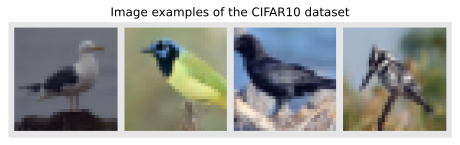

In [222]:
imsize = 256

test_transform = transforms.Compose([
                                    transforms.Resize(int(imsize * 76 / 64)),
                                    transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                    ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize(int(imsize * 76 / 64)),
                                    transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                    ])

image_transform = transforms.Compose([
    transforms.Resize(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
                                     
train_dataset = SpeechDataset(root='./../../data/birds', train=True, transform=train_transform)
val_dataset = SpeechDataset(root='./../../data/birds', train=True, transform=test_transform)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

test_set = SpeechDataset(root='./../../data/birds', train=False, transform=test_transform)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [123]:
val_set[0][0].shape

torch.Size([3, 256, 256])

Files already downloaded and verified
Files already downloaded and verified


Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


Files already downloaded and verified


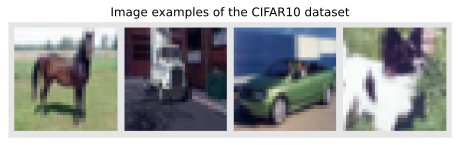

In [152]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])


train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [121]:
len(train_dataset)
9430 * 0.9
val_set[0][0].shape

torch.Size([3, 32, 32])

In [211]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

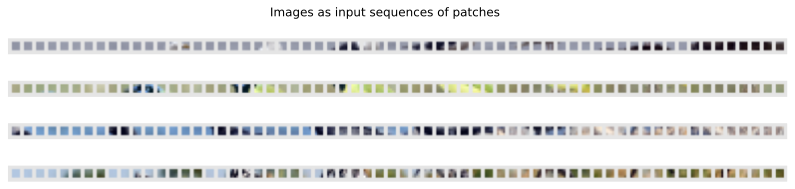

In [223]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [224]:
class AttentionBlock(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network 
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, 
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
        
    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [233]:
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and 
                      on the input encoding
        """
        super().__init__()
        
        print("num_classes: ----------------", num_classes)
        self.patch_size = patch_size
        
        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
    
    
    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        
        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [248]:
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]   

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        #imgs, caps, cls_id, key, labels = batch
        labels = labels.type(torch.LongTensor)
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss
  
    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [254]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"), 
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=1)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT-birds.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [255]:

model, results = train_model(model_kwargs={
                            'embed_dim': 256,
                            'hidden_dim': 512,
                            'num_heads': 8,
                            'num_layers': 6,
                            'patch_size': 4,
                            'num_channels': 3,
                            'num_patches': 64,
                            'num_classes': 200,
                            'dropout': 0.2
                            }
                            ,lr=3e-4)
print("ViT results", results)

GPU available: False, used: False
GPU available: False, used: False
GPU available: False, used: False
GPU available: False, used: False
GPU available: False, used: False
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


num_classes: ---------------- 200


/var/folders/tn/2lzs5bpd7359frdhy_czpt4h0000gn/T/ipykernel_2817/94495227.py:10: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)

  | Name  | Type              | Params | In sizes         | Out sizes 
----------------------------------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | [128, 3, 32, 32] | [128, 200]
----------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.976    Total estimated model params size (MB)

  | Name  | Type              | Params |

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/yimingxu/opt/anaconda3/envs/vunlp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
/Users/yimingxu/opt/anaconda3/envs/vunlp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 82:  20%|██        | 15/74 [01:46<06:57,  7.08s/it, loss=0.203, v_num=23]

/Users/yimingxu/opt/anaconda3/envs/vunlp/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


num_classes: ---------------- 200
Testing: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]
